In [1]:
# read dataset pascal
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
import sys
#print(sys.path)
sys.path.insert(0, '../')
from dpl import utils
from dpl.data.pascal import preprocessing

import keras
import multiprocessing
# 标签数据预处理
#preprocessing.split_label_into_masks("/home/super-workstation/Data/pascal/VOC_Data/VOC2012/SegmentationClass", "/mask1/")

import os
import cv2
    
from dpl.data.pascal.voc_data_generator import *
from dpl.data.pascal.voc_data_generator_v2 import *

image_root = "/home/super-workstation/Data/pascal/VOC_Data/VOC2012/"
path = image_root
# v1 get image and label
import yaml
with open("init_args.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

datagen = PascalVocGenerator(image_shape=[224, 224, 3],
                             image_resample=True,
                             pixelwise_center=True,
                             pixel_mean=[115.85100, 110.50989, 102.16182],
                             pixelwise_std_normalization=True,
                             pixel_std=[70.30930, 69.41244, 72.60676])

train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])
val_gen = datagen.flow_from_imageset(
        class_mode='categorical',
        classes=21,
        batch_size=5,
        shuffle=False,
        image_set_loader=val_loader)
batch = next(val_gen)
batch = next(val_gen)
print(batch[0].shape, batch[1].shape)
utils.showSingleImage(batch[0][0])
utils.showSingleImage(batch[1][0,:,:,17])

'''
# v2 get image and label
config = Config()
config.batch_size = 5
config.steps_per_epoch = 180
config.validation_steps = 40
config.shuffle=False
train_dataset = PascalDataset(path, is_train=True)
val_dataset = PascalDataset(path, is_train=False)

train_gen = data_generator(train_dataset, config)
val_gen = data_generator(val_dataset, config)

img_label = next(val_gen)
img_label = next(val_gen)
#print(img_label[1].shape)
utils.showSingleImage(img_label[0][0])
utils.showSingleImage(img_label[1][0,:,:,17])
'''


#print(img_label[0][0][100:200,:])

Using TensorFlow backend.
/home/super-workstation/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/super-workstation/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/super-workstation/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/super-workstation/.local/l

(5, 224, 224, 3) (5, 224, 224, 21)
info:
image size -->  224 x 224
channels -->  3


<Figure size 640x480 with 1 Axes>

info:
image size -->  224 x 224


<Figure size 640x480 with 1 Axes>

'\n# v2 get image and label\nconfig = Config()\nconfig.batch_size = 5\nconfig.steps_per_epoch = 180\nconfig.validation_steps = 40\nconfig.shuffle=False\ntrain_dataset = PascalDataset(path, is_train=True)\nval_dataset = PascalDataset(path, is_train=False)\n\ntrain_gen = data_generator(train_dataset, config)\nval_gen = data_generator(val_dataset, config)\n\nimg_label = next(val_gen)\nimg_label = next(val_gen)\n#print(img_label[1].shape)\nutils.showSingleImage(img_label[0][0])\nutils.showSingleImage(img_label[1][0,:,:,17])\n'

In [2]:
import sys
sys.path.insert(0, '../')
sys.path.insert(0, './segment')
import segment.fcn32s_net as fcn
import segment.fcn32s_net_v2 as fcnv2
from keras.optimizers import SGD

# model = fcn.create_fcn32s((500,500,3))
# sgd = SGD(lr=1e-4, momentum=0.9)
# metrics=["accuracy", utils.mean_iou]
#model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)
#print(model.summary())
#model.load_weights("./check_points/_weights.hdf5")
#predicts = model.predict_on_batch(batch[0])
#scores = model.test_on_batch(batch[0], batch[1])
#print(scores)

model = fcn.create_fcn32s((224,224,3))
model.load_weights("./check_points/fcn32s_net_weights.hdf5")
w = model.get_weights()
print(w[0])

W0906 19:33:44.064179 139740872193856 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 19:33:44.073041 139740872193856 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 19:33:44.074726 139740872193856 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0906 19:33:44.095697 139740872193856 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf

[[[[ 3.76057237e-01  4.58870083e-02  5.31444000e-03 ... -1.10157877e-01
    -4.58623357e-02  4.78395540e-03]
   [ 4.75303948e-01  2.76345550e-03  1.83919799e-02 ... -6.83826283e-02
    -4.26967964e-02  2.59396173e-02]
   [ 4.12765026e-01 -7.83351660e-02  2.20957072e-03 ... -9.96419638e-02
    -4.51440625e-02  2.23917589e-02]]

  [[ 3.27167004e-01  6.62933737e-02 -9.71177651e-04 ... -1.23203874e-01
    -2.04628721e-01 -4.81799245e-02]
   [ 3.81617010e-01  1.54323056e-02  9.52352304e-03 ... -7.99341723e-02
    -2.53304213e-01 -5.22874296e-02]
   [ 3.52577925e-01 -7.63118714e-02 -4.99542104e-03 ... -9.83390808e-02
    -2.37944409e-01 -2.98829284e-02]]

  [[-5.14210612e-02  5.43637052e-02 -3.27346325e-02 ... -1.17508471e-01
    -3.31601501e-01 -2.38578871e-01]
   [-6.88132122e-02  1.22593790e-02 -2.78768837e-02 ... -7.74484798e-02
    -4.36002344e-01 -2.97300369e-01]
   [-5.42729869e-02 -6.99648112e-02 -3.69860530e-02 ... -1.02204137e-01
    -3.99043292e-01 -2.48612538e-01]]]


 [[[ 2.3996

In [3]:
from PIL import Image
def predict_image(model, image):
    input_p = np.zeros((1, image.shape[0], image.shape[1], image.shape[2]))
    input_p[0] = image
    predict = model.predict(input_p)
    seg = np.argmax(predict[0], axis=-1).astype(np.uint8)
    result = Image.fromarray(seg, mode='P')
    return result
    
re = predict_image(model, batch[0][0])
re.save("inference.png")
re.show()

(5, 224, 224)
info:
image size -->  224 x 224


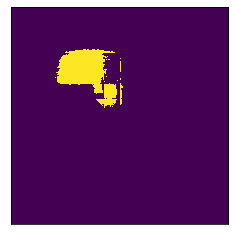

W0906 19:34:05.931634 139740872193856 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


info:
image size -->  224 x 224
channels -->  3


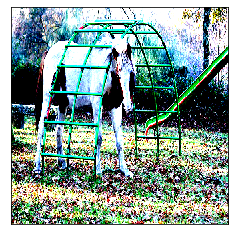

In [5]:
# predicts = model.predict_on_batch(batch[0])
# print(predicts[0])
predicts = model.predict_on_batch(batch[0])
#print(predicts)
imgs = np.argmax(predicts, axis=-1).astype(np.bool)
# print(imgs[0])
print(imgs.shape)
utils.showSingleImage(imgs[3])
utils.showSingleImage(batch[0][3])
# utils.showSingleImage(batch[0][1])

In [9]:
import numpy as np
import keras
import keras.backend as K
from keras.models import load_model
from dpl.data.pascal.voc_data_generator import PascalVocGenerator, ImageSetLoader
from dpl.utils import BilinearUpSampling2D

import yaml
with open("init_args.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

datagen = PascalVocGenerator(image_shape=[500, 500, 3],
                             image_resample=True,
                             pixelwise_center=True,
                             pixel_mean=[115.85100, 110.50989, 102.16182],
                             pixelwise_std_normalization=True,
                             pixel_std=[70.30930, 69.41244, 72.60676])
dataload = ImageSetLoader(**init_args['image_set_loader']['train'])

model = load_model('./check_points/fcn32s_v2+_weights.hdf5',
        custom_objects={'BilinearUpSampling2D': BilinearUpSampling2D})
print(model.summary())


# for fn in dataload.filenames[:10]:
#     x = dataload.load_img(fn)
#     x = datagen.standardize(x)
#     print(x.min(), x.max())
#     X = x[np.newaxis, ...]
#     label = dataload.load_seg(fn)
#     label = np.squeeze(label, axis=-1).astype('int')
#     y_enc = np.eye(21)[label]
#     y_true = y_enc[np.newaxis, ...]
#     result = model.evaluate(X, y_true)

#     y_pred = model.predict(X)
#     print(np.unique(y_true), np.unique(y_pred))
#     loss = keras.losses.categorical_crossentropy(K.variable(y_true), K.variable(y_pred))
#     print(y_true.shape, y_pred.shape)
#     print(result, K.eval(loss))

#     pred = np.argmax(y_pred, axis=-1)
#     pred = pred[..., np.newaxis]
#     pred = np.squeeze(pred, axis=0)
#     print(np.unique(label), np.unique(pred))
#     print(np.size(label), np.sum(label != 0))


/home/super-workstation/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  # This is added back by InteractiveShellApp.init_path()


ValueError: Cannot create group in read only mode.